#  Demand_Forecasting

### importing the libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xg
import os 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

### import the dataset

In [2]:
dataset = pd.read_csv('Food demand.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [3]:
dataset

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1000000,3,157,2760,233.83,231.83,0,0,149
1,1000001,100,104,2956,486.03,583.03,0,0,161
2,1000002,143,75,1971,328.86,327.86,0,0,149
3,1000003,41,24,2539,145.53,145.53,0,0,540
4,1000004,45,83,2539,95.06,120.34,0,0,271
...,...,...,...,...,...,...,...,...,...
1994,1002177,89,72,1311,130.04,177.51,0,0,68
1995,1002178,24,50,2444,604.31,606.31,0,0,109
1996,1002179,43,88,1971,291.06,291.06,0,0,366
1997,1002180,107,58,1543,473.39,473.39,0,1,42


In [4]:
dataset.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders'],
      dtype='object')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1999 non-null   int64  
 1   week                   1999 non-null   int64  
 2   center_id              1999 non-null   int64  
 3   meal_id                1999 non-null   int64  
 4   checkout_price         1999 non-null   float64
 5   base_price             1999 non-null   float64
 6   emailer_for_promotion  1999 non-null   int64  
 7   homepage_featured      1999 non-null   int64  
 8   num_orders             1999 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.7 KB


In [6]:
df=dataset.drop(["week","id","center_id","meal_id"], axis=1)
df

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,233.83,231.83,0,0,149
1,486.03,583.03,0,0,161
2,328.86,327.86,0,0,149
3,145.53,145.53,0,0,540
4,95.06,120.34,0,0,271
...,...,...,...,...,...
1994,130.04,177.51,0,0,68
1995,604.31,606.31,0,0,109
1996,291.06,291.06,0,0,366
1997,473.39,473.39,0,1,42


<AxesSubplot:>

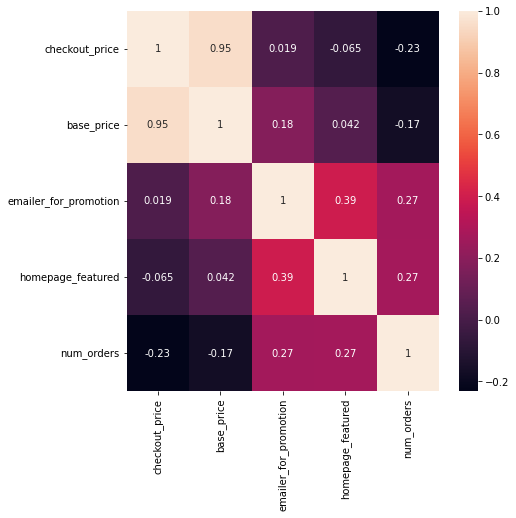

In [7]:
df.corr()
fig = plt.figure(figsize = (7,7))
sns.heatmap(df.corr(), annot = True)

Text(0, 0.5, 'no_of_orders')

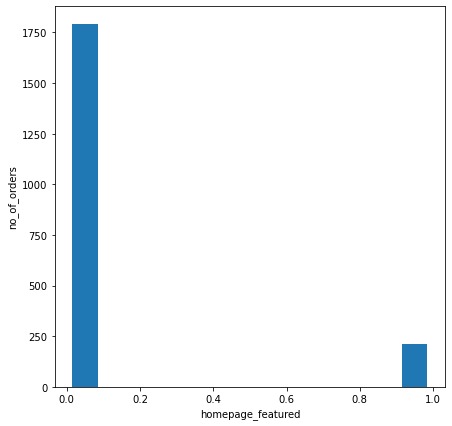

In [8]:
fig = plt.figure(figsize = (7,7))
plt.hist(df['homepage_featured'], rwidth=0.7)
plt.xlabel('homepage_featured')
plt.ylabel('no_of_orders')

In [34]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Food demand.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('Food demand.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'Food demand.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 9 columns


In [35]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [36]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [37]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


C:\Users\abhij\AppData\Local\Temp\ipykernel_19436\2970181590.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


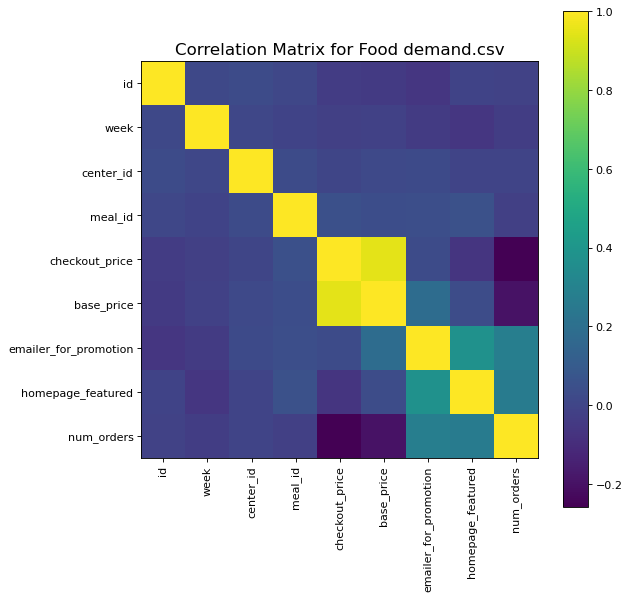

In [39]:
plotCorrelationMatrix(df1, 8)

C:\Users\abhij\AppData\Local\Temp\ipykernel_19436\950191735.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


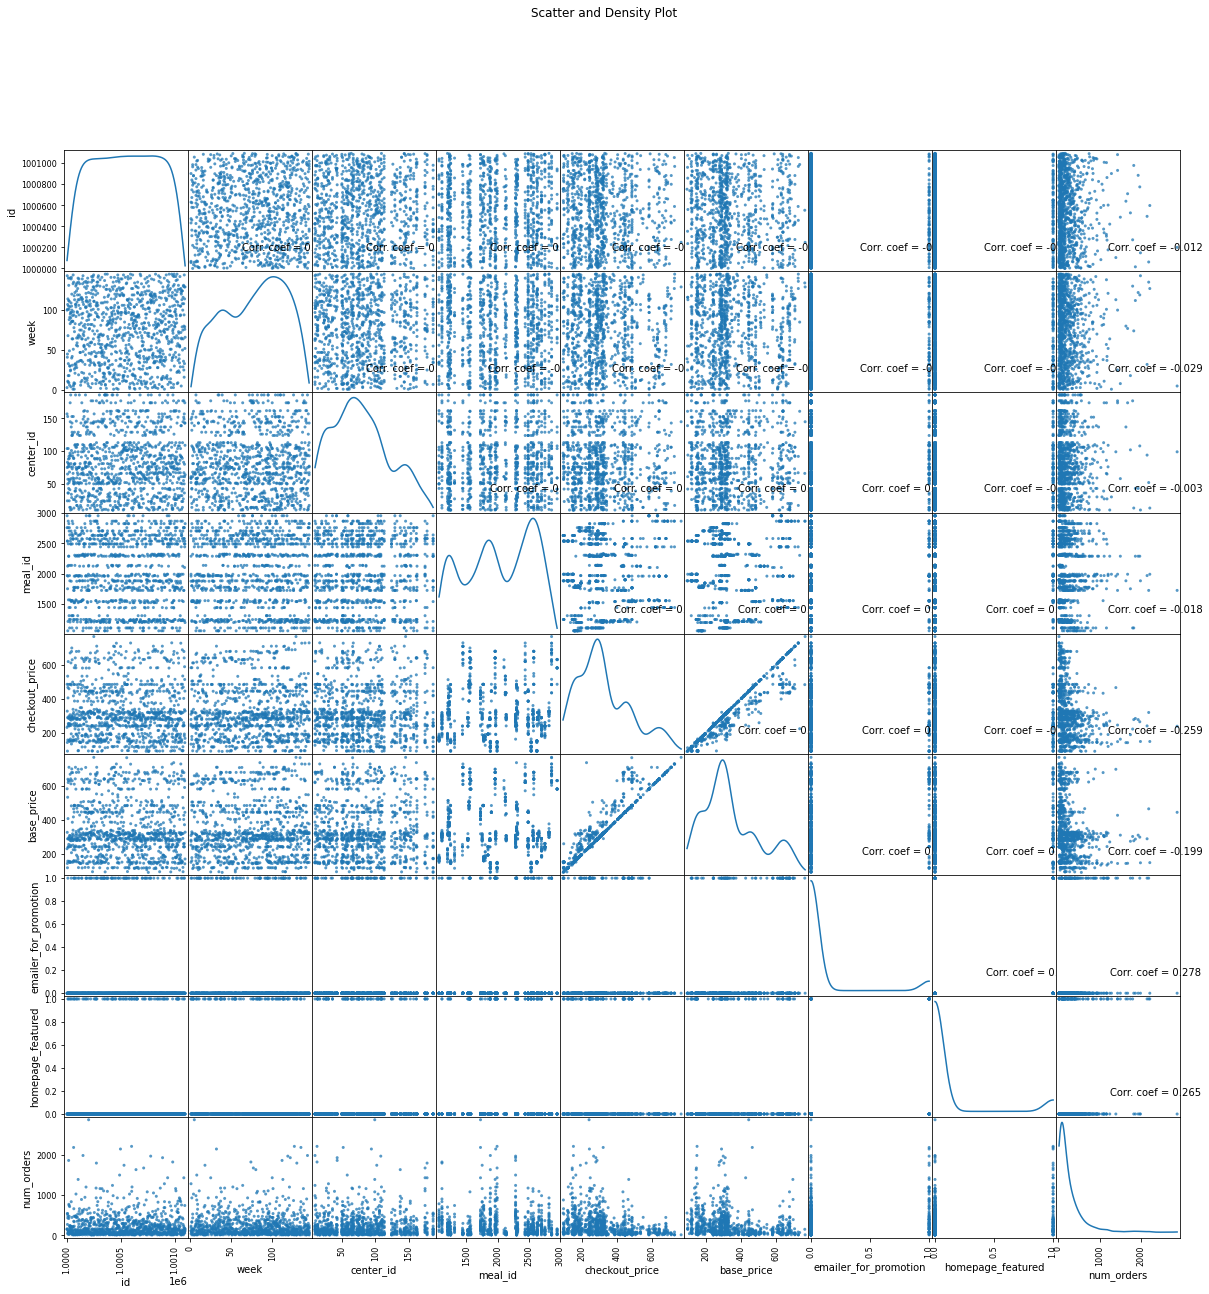

In [40]:
plotScatterMatrix(df1, 20, 10)

Text(0, 0.5, 'no_of_orders')

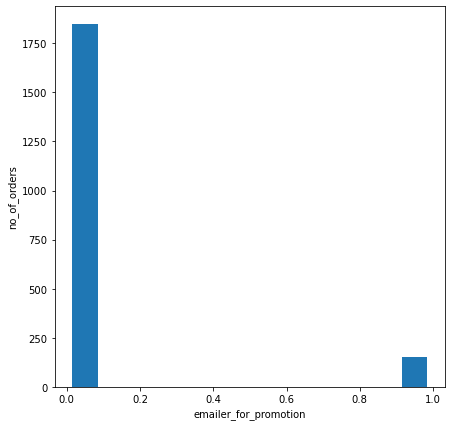

In [9]:
fig = plt.figure(figsize = (7,7))
plt.hist(df['emailer_for_promotion'], rwidth=0.7)
plt.xlabel('emailer_for_promotion')
plt.ylabel('no_of_orders')

Text(0, 0.5, 'no_of_orders')

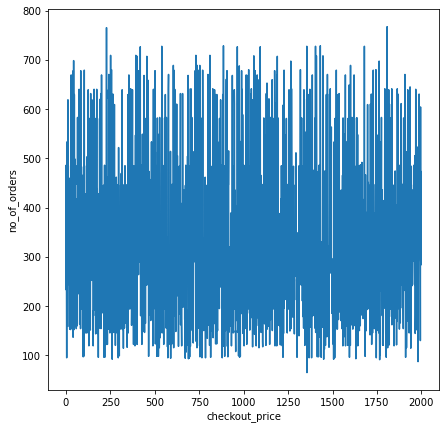

In [10]:
fig = plt.figure(figsize = (7,7))
plt.plot(dataset['checkout_price'])
plt.xlabel('checkout_price')
plt.ylabel('no_of_orders')

### SPLITTING THE DATA INTO TRAINING AND TEST DATASETS

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [12]:
len(X_train)

1599

In [13]:
len(X_test)

400

### XGBoost

In [14]:
from xgboost import XGBRegressor

In [15]:
xgreg=XGBRegressor()

In [16]:
xgreg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [17]:
y_pred=xgreg.predict(X_test)

In [18]:
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[ 2.61e+02  2.83e+02]
 [ 3.59e+02  1.88e+02]
 [ 1.57e+01  2.80e+01]
 [ 3.38e+01  2.60e+01]
 [ 1.39e+01  2.80e+01]
 [ 8.44e+02  9.71e+02]
 [ 3.15e+02  3.23e+02]
 [ 7.18e+01  2.97e+02]
 [ 6.43e+02  3.51e+02]
 [ 7.60e+01  3.12e+02]
 [-7.12e-02  1.07e+02]
 [ 2.74e+02  2.84e+02]
 [ 1.12e+02  1.75e+02]
 [ 1.45e+02  2.43e+02]
 [ 1.03e+03  1.50e+03]
 [ 1.04e+02  1.49e+02]
 [ 1.63e+02  1.36e+02]
 [ 9.50e+01  2.70e+01]
 [ 3.16e+02  1.49e+02]
 [ 6.30e+01  1.35e+02]
 [ 1.73e+02  1.61e+02]
 [ 2.91e+02  2.70e+02]
 [ 4.38e+02  6.70e+01]
 [ 7.98e+02  1.82e+03]
 [ 6.29e+01  1.34e+02]
 [ 2.92e+02  5.01e+02]
 [ 4.44e+02  2.31e+02]
 [ 3.27e+02  5.94e+02]
 [ 1.70e+02  1.34e+02]
 [ 1.71e+02  9.60e+01]
 [ 2.98e+02  2.58e+02]
 [ 2.70e+02  2.43e+02]
 [ 2.21e+02  5.40e+01]
 [ 2.03e+02  2.97e+02]
 [ 4.19e+02  2.69e+02]
 [ 2.88e+02  2.98e+02]
 [ 3.44e+02  3.65e+02]
 [ 5.14e+02  9.85e+02]
 [ 2.30e+02  2.60e+01]
 [ 4.37e+02  2.30e+02]
 [ 6.64e+01  2.80e+01]
 [ 1.47e+02  9.40e+01]
 [ 3.75e+01  2.70e+01]
 [ 2.00e+02

In [19]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.41607397161862536

### Random Forest Regression

In [20]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [21]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[ 163.7  283. ]
 [ 491.7  188. ]
 [  74.2   28. ]
 [  55.3   26. ]
 [  37.7   28. ]
 [ 679.4  971. ]
 [ 298.4  323. ]
 [  77.1  297. ]
 [ 712.3  351. ]
 [ 132.6  312. ]
 [  65.7  107. ]
 [ 303.8  284. ]
 [  75.1  175. ]
 [ 240.9  243. ]
 [1061.5 1499. ]
 [  86.6  149. ]
 [ 328.   136. ]
 [  31.7   27. ]
 [ 455.3  149. ]
 [  59.   135. ]
 [ 236.3  161. ]
 [ 209.5  270. ]
 [ 263.5   67. ]
 [ 508.  1824. ]
 [  62.3  134. ]
 [ 328.7  501. ]
 [ 437.   231. ]
 [ 309.5  594. ]
 [ 248.8  134. ]
 [ 382.4   96. ]
 [ 395.8  258. ]
 [ 386.2  243. ]
 [ 303.    54. ]
 [ 279.9  297. ]
 [ 527.1  269. ]
 [ 278.3  298. ]
 [ 418.8  365. ]
 [ 377.2  985. ]
 [ 311.1   26. ]
 [ 414.1  230. ]
 [  43.4   28. ]
 [ 384.9   94. ]
 [  39.    27. ]
 [ 139.   242. ]
 [  42.6   42. ]
 [ 577.4  555. ]
 [ 166.4  190. ]
 [ 589.1   69. ]
 [ 509.7  324. ]
 [ 448.6  324. ]
 [ 992.1  148. ]
 [  72.2  177. ]
 [ 302.8  190. ]
 [ 503.1   26. ]
 [ 444.2  568. ]
 [  50.3   54. ]
 [  70.5   40. ]
 [ 176.7  229. ]
 [ 406.5  310.

In [22]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.3429296937458063